# 文件分類

**Author:** 黃天原  
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：股市、運動、兩岸  

* 分析主題：將聯合新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

Text(0.5, 1.0, '聲量圖')

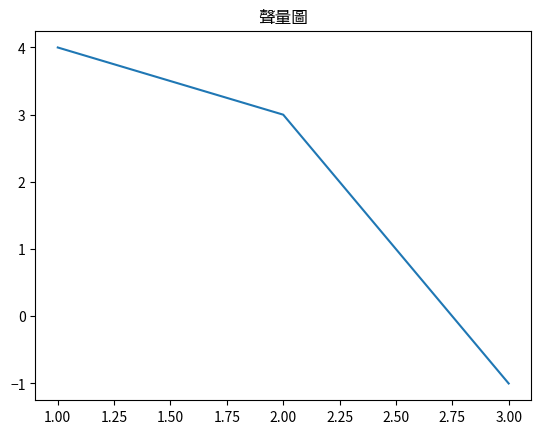

In [2]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`udn_news_03.csv`裡面包含了要分析的 udn 新聞資料。首先我們先看文集的基本資料，並做文集前處理。

In [3]:
udn = pd.read_csv("raw_data/udn_news_03.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽／夠經典！大聯盟拍賣網站 潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在3月8日開打，大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標，目前所有...,UDN
1,2,經典賽／神秘巴拿馬30人名單揭曉 5大聯盟+1前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在3月8日開打，中華隊首戰對手巴拿馬隊今天公布最終30人名單，其中有5名現役...,UDN
2,3,經典賽／大谷翔平發文宣告與日本隊合體 何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周3月8日開打，將代表日本出征的大谷翔平今天進行春訓初登板，賽後馬上啟程...,UDN


In [4]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


number of posts: 5985
date range: ('2023-03-01 07:00:00', '2023-03-31 23:39:00')
category: 
股市    2211
運動    2009
兩岸    1765
Name: artCatagory, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [5]:
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標目前所有拍賣物品...,UDN
1,2,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今天公布最終人名單其中有名現役大聯盟球員還有...,UDN
2,3,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周月日開打將代表日本出征的大谷翔平今天進行春訓初登板賽後馬上啟程返日準備...,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [6]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出...,https://udn.com/news/story/10785/7001130,運動
1,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今...,https://udn.com/news/story/10785/7001237,運動
2,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定世界棒球經典賽將在下周月日開打將代表日本出...,https://udn.com/news/story/10785/7002171,運動
3,經典賽鄧愷威搭上飛機了日會合中華隊日登板旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表...,https://udn.com/news/story/10785/7002266,運動
4,經典賽古巴隊會藏中華隊餅總保持戒心古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊...,https://udn.com/news/story/10785/7002313,運動


In [7]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 5985


### 2.2 斷詞

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [10]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from /home/evan19983314/SMA/SMA_2023S/week11_classification/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.uf86e896fa1a801cc442cbab0bb7b6f1d.cache
Loading model cost 1.775 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出...,https://udn.com/news/story/10785/7001130,運動,經典 賽夠 經典 聯盟 拍賣 網站 潘威倫 球衣 出價 最高 世界 棒球 經典 賽將 開打 ...
1,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今...,https://udn.com/news/story/10785/7001237,運動,經典 神秘 巴拿馬人 名單 揭曉 聯盟 中職 洋投 世界 棒球 經典 賽將 開打 中華隊 首...
2,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定世界棒球經典賽將在下周月日開打將代表日本出...,https://udn.com/news/story/10785/7002171,運動,經典 大谷 翔平 發文 宣告 日本隊 合體 出賽 還不 確定 世界 棒球 經典 賽將 下周 ...
3,經典賽鄧愷威搭上飛機了日會合中華隊日登板旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表...,https://udn.com/news/story/10785/7002266,運動,經典 鄧愷威 飛機 會合 中華隊 日登板 旅美 投手 鄧愷威 加入 中華隊 時間 出爐 總教...
4,經典賽古巴隊會藏中華隊餅總保持戒心古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊...,https://udn.com/news/story/10785/7002313,運動,經典 古巴隊 會藏 中華隊 餅總 保持 戒心 古巴隊 昨天 擊敗 味全 下來 熱身賽 首勝 ...


### 2.3 資料集基本檢視

檢視資料內容

In [11]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 5985
category: 
股市    2211
運動    2009
兩岸    1765
Name: artCatagory, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [12]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

1576    杜拜 網賽 克維奇 輸給 梅德維夫 今年 連勝 句點 塞爾維亞 網球 名將 克維奇 今天 杜...
3944    宏捷科 目標價 大摩喊 摩根士丹利 砷化鎵 產業 智慧 手機 功率 放大器 出貨量 有所 轉...
1366    喬治 膝傷 不用 開刀 樂觀 季後賽 首輪 歸隊 快艇 當家 球星 喬治 昨天 傳出 右膝 ...
713     經典 彈力 惡夢 悄悄 襲來 中華隊 熱身賽 全勝 無法 樂觀 第屆 經典 賽組 預賽 台灣...
5951    河南 名校 女靠 拾荒 月入 破萬稱 實現 財務 自由 河南 有個 名校 畢業 女生 毅然 ...
Name: words, dtype: object
1576    運動
3944    股市
1366    運動
713     運動
5951    兩岸
Name: artCatagory, dtype: object


In [13]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
股市    36.942356
運動    33.567251
兩岸    29.490393
Name: artCatagory, dtype: float64

train percentage :
股市    36.619718
運動    33.802817
兩岸    29.577465
Name: artCatagory, dtype: float64

test percentage :
股市    37.694878
運動    33.017817
兩岸    29.287305
Name: artCatagory, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)

在這裡我們用簡單的四個中文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數。

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [14]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [15]:
X_train.head()

1576    杜拜 網賽 克維奇 輸給 梅德維夫 今年 連勝 句點 塞爾維亞 網球 名將 克維奇 今天 杜...
3944    宏捷科 目標價 大摩喊 摩根士丹利 砷化鎵 產業 智慧 手機 功率 放大器 出貨量 有所 轉...
1366    喬治 膝傷 不用 開刀 樂觀 季後賽 首輪 歸隊 快艇 當家 球星 喬治 昨天 傳出 右膝 ...
713     經典 彈力 惡夢 悄悄 襲來 中華隊 熱身賽 全勝 無法 樂觀 第屆 經典 賽組 預賽 台灣...
5951    河南 名校 女靠 拾荒 月入 破萬稱 實現 財務 自由 河南 有個 名校 畢業 女生 毅然 ...
Name: words, dtype: object

In [16]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<4189x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 273490 stored elements in Compressed Sparse Row format>

In [17]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names()[:10])


['一些', '一位', '一名', '一場', '一天', '一定', '一年', '一度', '一戰', '一次']


In [19]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'輸給': 873, '今年': 77, '連勝': 893, '今天': 76, '錦標賽': 929, '俄羅斯': 98, '好手': 301, '贏球': 861, '表現': 808, '報導': 271, '擊敗': 469, '將在': 333, '決賽': 599, '衛冕': 806, '第一': 707, '去年': 202, '奪冠': 298, '以來': 84, '一直': 10, '保持': 100, '紀錄': 724, '對戰': 338, '取得': 209, '勝利': 186, '產業': 650, '智慧': 532, '手機': 422, '出貨': 159, '動能': 185, '維持': 745, '大盤': 287, '指出': 445, '業者': 570, '採取': 454, '積極': 699, '價格': 111, '策略': 716, '預期': 975, '未來': 552, '營收': 621, '看好': 686, '來自': 93, '業務': 568, '提升': 465, '庫存': 376, '第季': 712, '訂單': 824, '來說': 94, '三大': 15, '客戶': 324, '主要': 50, '科技': 697, '相關': 684, '供應鏈': 96, '目前': 677, '穩健': 700, '延續': 377, '觀察': 821, '自年': 783, '大幅': 283, '幅度': 367, '系統': 723, '出現': 157, '回升': 250, '市場': 360, '展望': 348, '調整': 839, '獲利': 631, '上半年': 20, '可望': 219, '過去': 901, '保守': 99, '提高': 466, '競爭': 705, '空間': 702, '樂觀': 572, '季後賽': 307, '首輪': 989, '快艇': 396, '球星': 641, '昨天': 522, '傳出': 107, '例行': 95, '消息': 607, '確定': 693, '需要': 965, '無法': 618, '登場': 662, '狀況': 628, '代表': 81, '機會': 575, '亮相': 6

0

In [20]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(4189, 1000)
(1796, 1000)


In [21]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [22]:
clf.classes_


array(['兩岸', '股市', '運動'], dtype=object)

In [23]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['兩岸' '股市' '運動' '股市' '股市' '兩岸' '股市' '股市' '股市' '運動']


In [24]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1796, 3)


array([1.00000000e+00, 5.27880162e-11, 4.21584513e-11])

In [25]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



In [26]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[518,   8,   0],
       [  7, 669,   1],
       [  4,   0, 589]])

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '兩岸'), Text(0, 1.5, '股市'), Text(0, 2.5, '運動')])

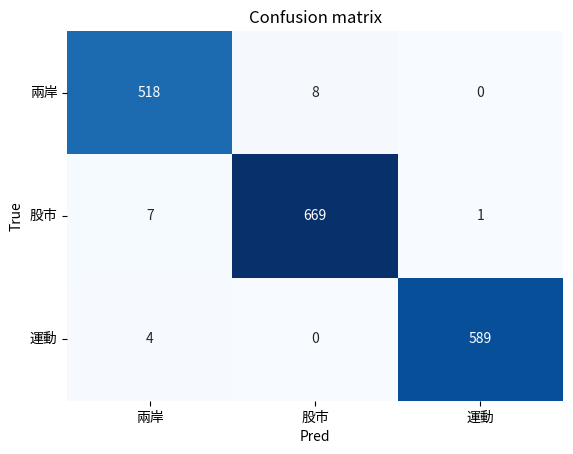

In [27]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [28]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
print(y_onehot_test.shape)  # (n_samples, n_classes)
y_onehot_test[0,:]

(1796, 3)


array([1, 0, 0])

In [29]:
y_test.iloc[0]

'兩岸'

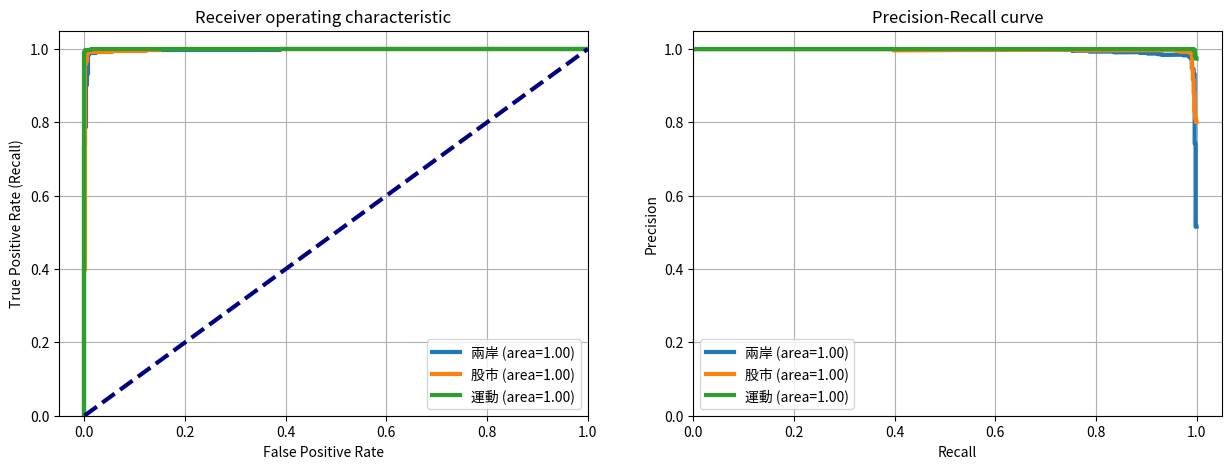

In [30]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()


### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [31]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16208138, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [32]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.98      0.99      0.99       677
          運動       1.00      0.99      0.99       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



效果一樣也是不錯，可能因為三格新聞版別本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [33]:
clf = LogisticRegression()
vec_train = CountVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.1831367 , 0.2053721 , 0.20381737, 0.22880912, 0.18012238]),
 'score_time': array([0.01181698, 0.01155877, 0.01100397, 0.01228094, 0.01043081]),
 'test_f1_macro': array([0.98660048, 0.9757206 , 0.98282789, 0.98672167, 0.98779305]),
 'test_precision_macro': array([0.98700658, 0.97569172, 0.98230507, 0.98670906, 0.98871405]),
 'test_recall_macro': array([0.9862341 , 0.97583175, 0.98348965, 0.98674698, 0.98703223])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [34]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          兩岸       0.97      0.98      0.98      1239
          股市       0.98      0.99      0.98      1534
          運動       1.00      0.99      0.99      1416

    accuracy                           0.98      4189
   macro avg       0.98      0.98      0.98      4189
weighted avg       0.98      0.98      0.98      4189



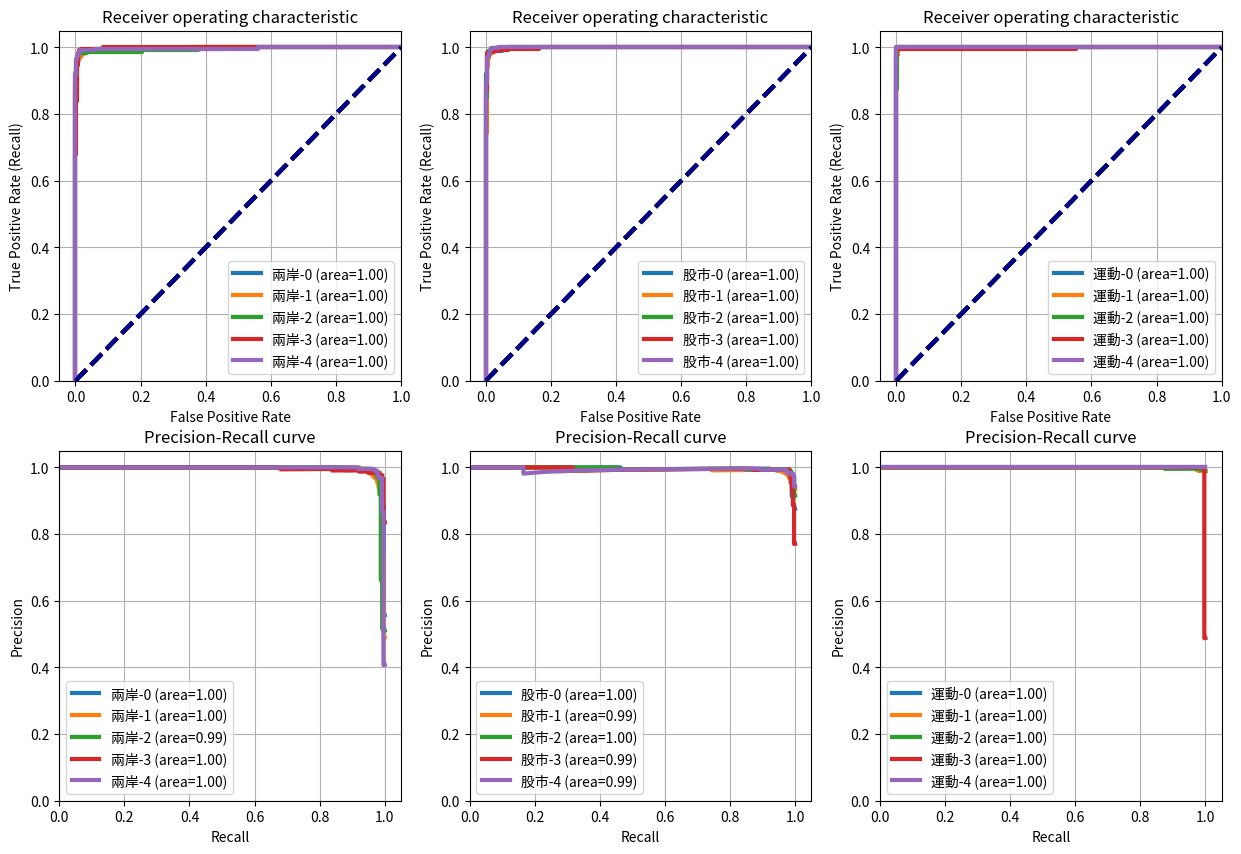

In [35]:
## 將三個新聞類別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

## 4. 比較不同模型效果

In [36]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          兩岸       0.97      0.98      0.98      1239
          股市       0.98      0.99      0.98      1534
          運動       1.00      0.99      0.99      1416

    accuracy                           0.98      4189
   macro avg       0.98      0.98      0.98      4189
weighted avg       0.98      0.98      0.98      4189



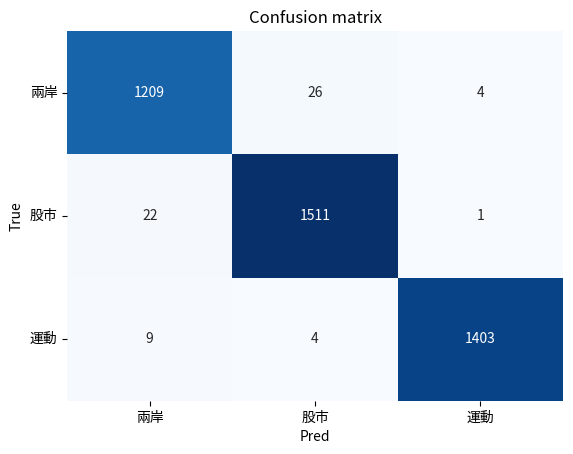

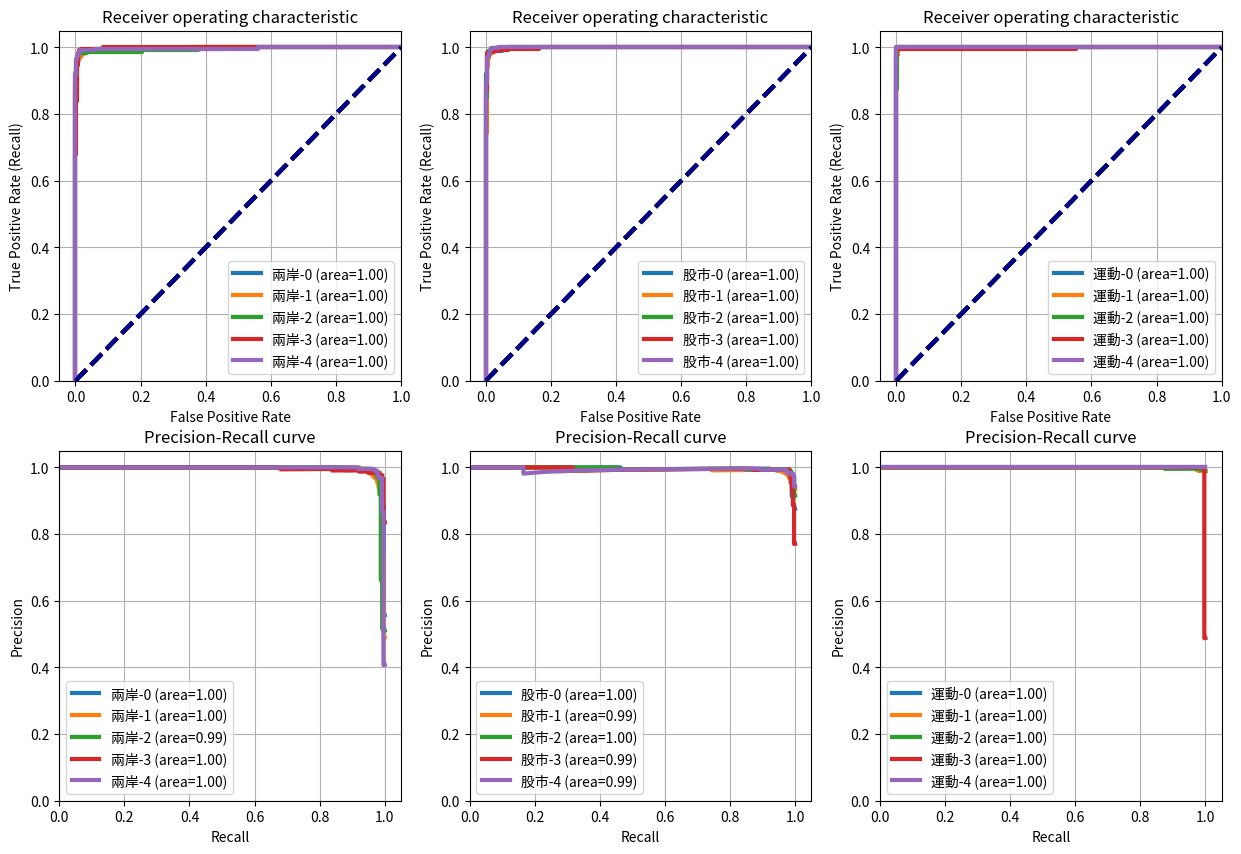

In [37]:
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          兩岸       0.97      0.98      0.98      1239
          股市       0.98      0.99      0.98      1534
          運動       1.00      0.99      0.99      1416

    accuracy                           0.98      4189
   macro avg       0.98      0.98      0.98      4189
weighted avg       0.98      0.98      0.98      4189



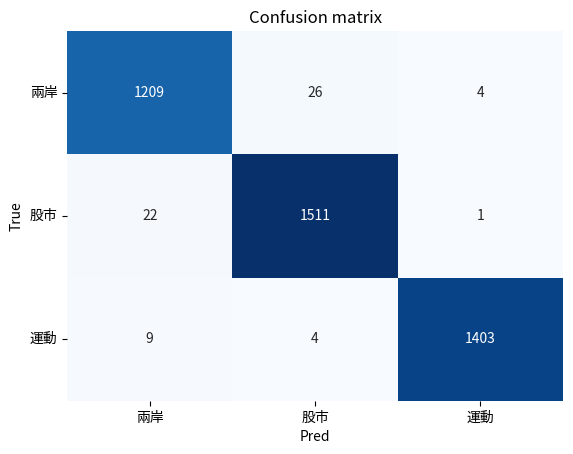

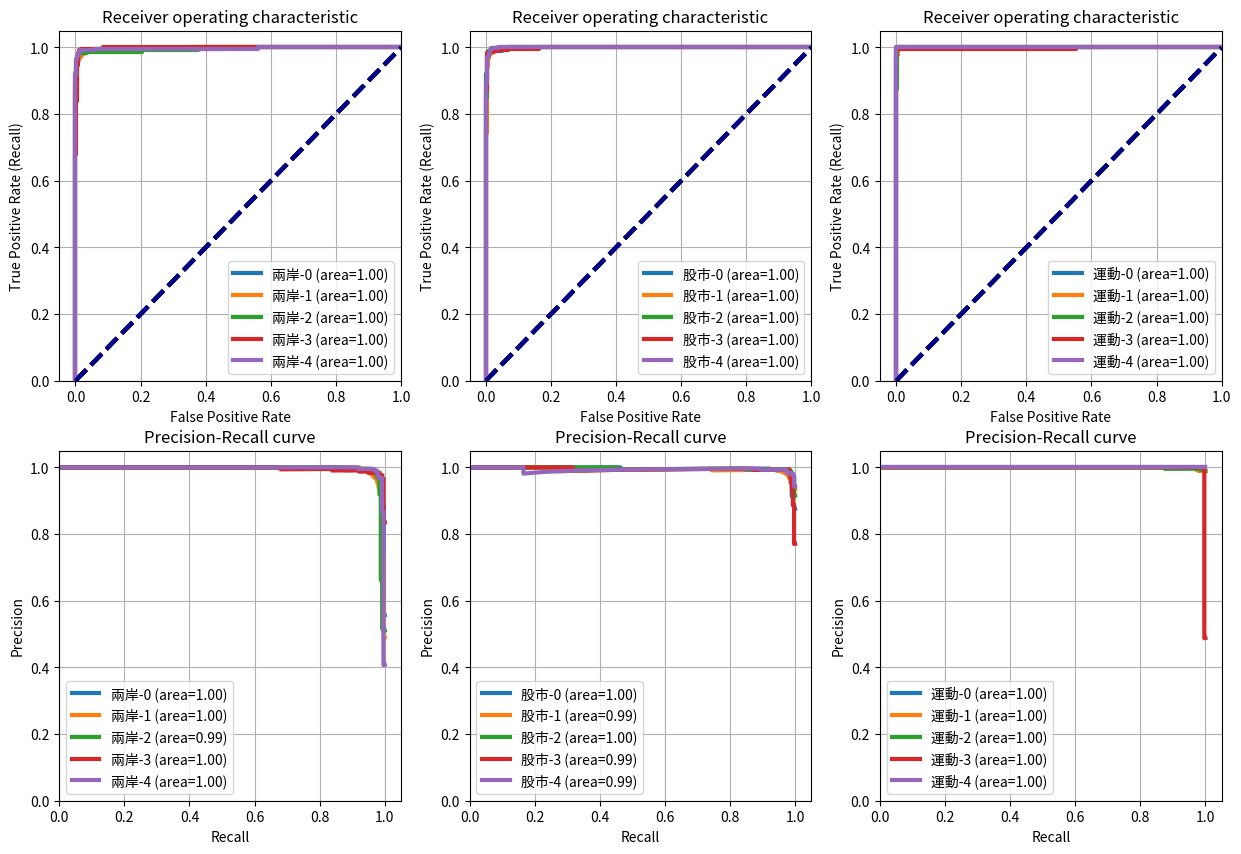

now training: clf_dtree
              precision    recall  f1-score   support

          兩岸       0.93      0.93      0.93      1239
          股市       0.94      0.95      0.94      1534
          運動       0.99      0.98      0.98      1416

    accuracy                           0.95      4189
   macro avg       0.95      0.95      0.95      4189
weighted avg       0.95      0.95      0.95      4189



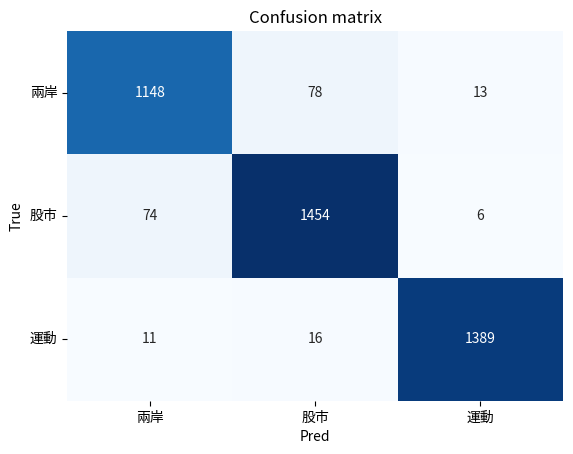

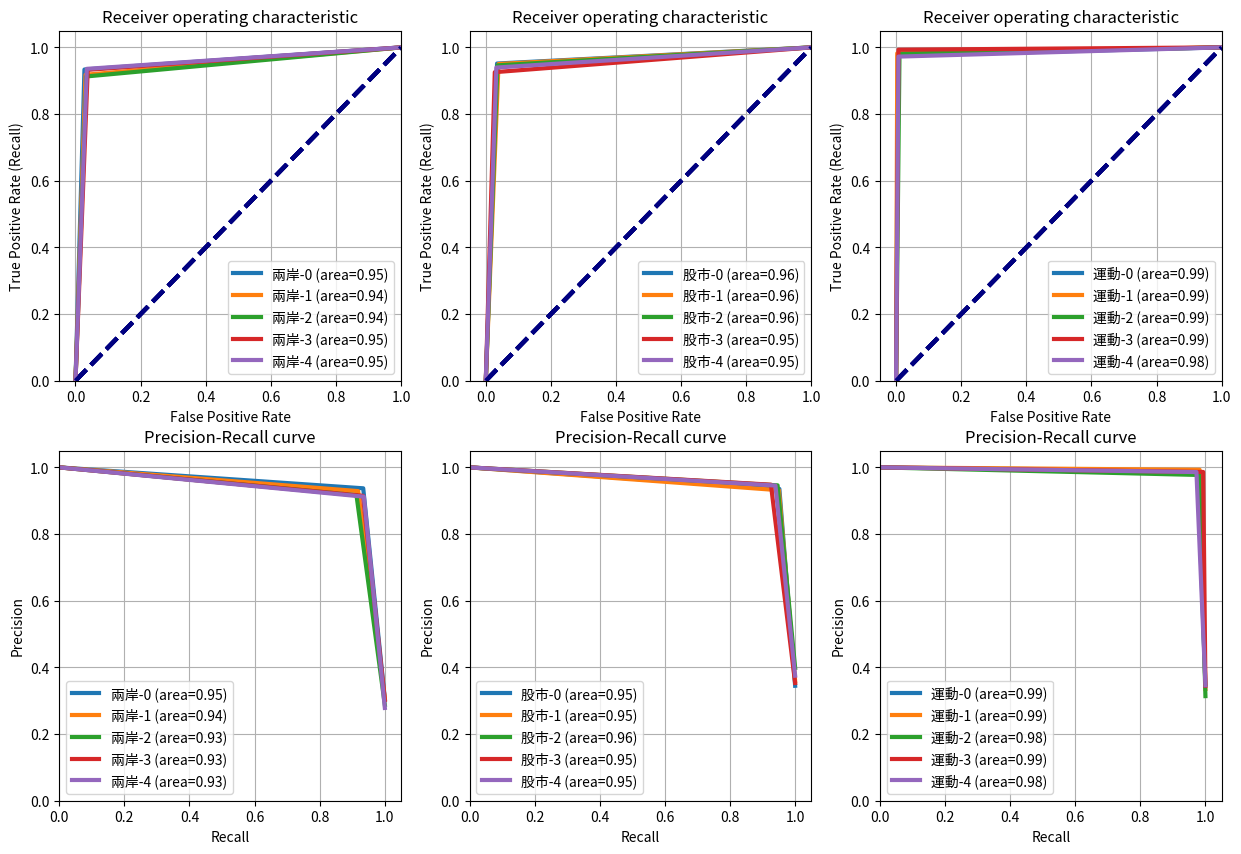

In [38]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [39]:
result_set['clf_logistic']

{'兩岸': {'precision': 0.975,
  'recall': 0.9757869249394673,
  'f1-score': 0.9753933037515127,
  'support': 1239},
 '股市': {'precision': 0.9805321219987021,
  'recall': 0.9850065189048239,
  'f1-score': 0.9827642276422763,
  'support': 1534},
 '運動': {'precision': 0.9964488636363636,
  'recall': 0.990819209039548,
  'f1-score': 0.9936260623229461,
  'support': 1416},
 'accuracy': 0.9842444497493436,
 'macro avg': {'precision': 0.9839936618783552,
  'recall': 0.9838708842946131,
  'f1-score': 0.983927864572245,
  'support': 4189},
 'weighted avg': {'precision': 0.9842761675949152,
  'recall': 0.9842444497493436,
  'f1-score': 0.984255701313122,
  'support': 4189}}

In [40]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9842444497493436,
 'macro avg': {'f1-score': 0.983927864572245,
               'precision': 0.9839936618783552,
               'recall': 0.9838708842946131,
               'support': 4189},
 'weighted avg': {'f1-score': 0.984255701313122,
                  'precision': 0.9842761675949152,
                  'recall': 0.9842444497493436,
                  'support': 4189},
 '兩岸': {'f1-score': 0.9753933037515127,
        'precision': 0.975,
        'recall': 0.9757869249394673,
        'support': 1239},
 '股市': {'f1-score': 0.9827642276422763,
        'precision': 0.9805321219987021,
        'recall': 0.9850065189048239,
        'support': 1534},
 '運動': {'f1-score': 0.9936260623229461,
        'precision': 0.9964488636363636,
        'recall': 0.990819209039548,
        'support': 1416}}


In [41]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



In [42]:
model_set['clf_logistic'].predict(vectorizer.transform(["市場 將 迎來 許多 大企業 的 財報 美國 股市 主要指數 今天 早盤 小幅震盪"]))

array(['股市'], dtype=object)

* logistic 的模型表現比決策樹的略好一點。
* 另外也可以嘗試用 tfidf 作為 `vectorizer`，比較看看相較直接的詞頻表，是否效果更好。
* 當 label 的類別不平衡的時候，會需要用其他手法或更複雜的模型，來解決資料類別不平衡的問題

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [43]:
model_set[best_model_name]

LogisticRegression()

In [44]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

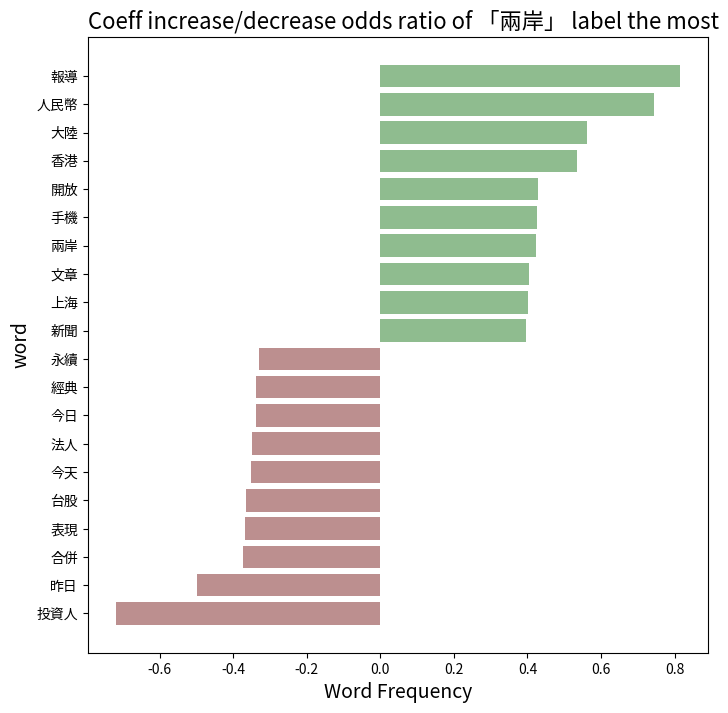

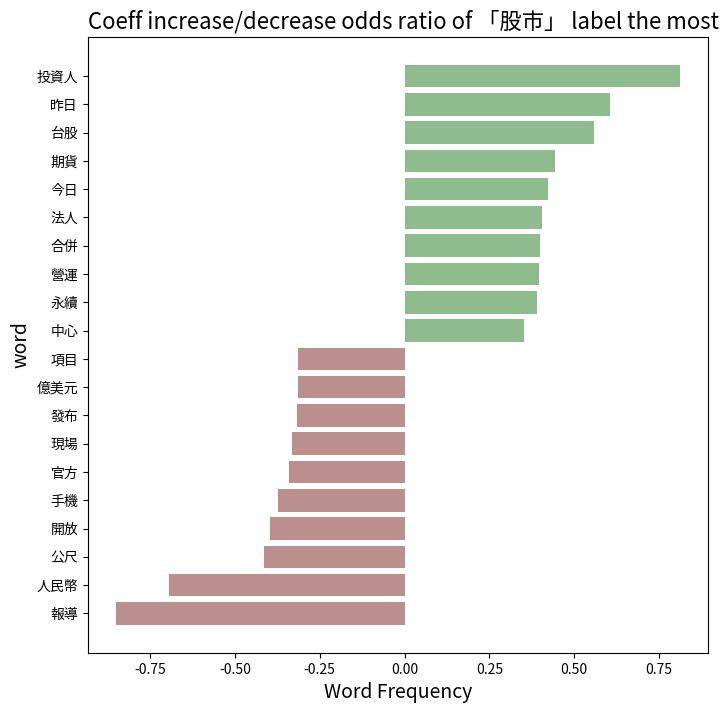

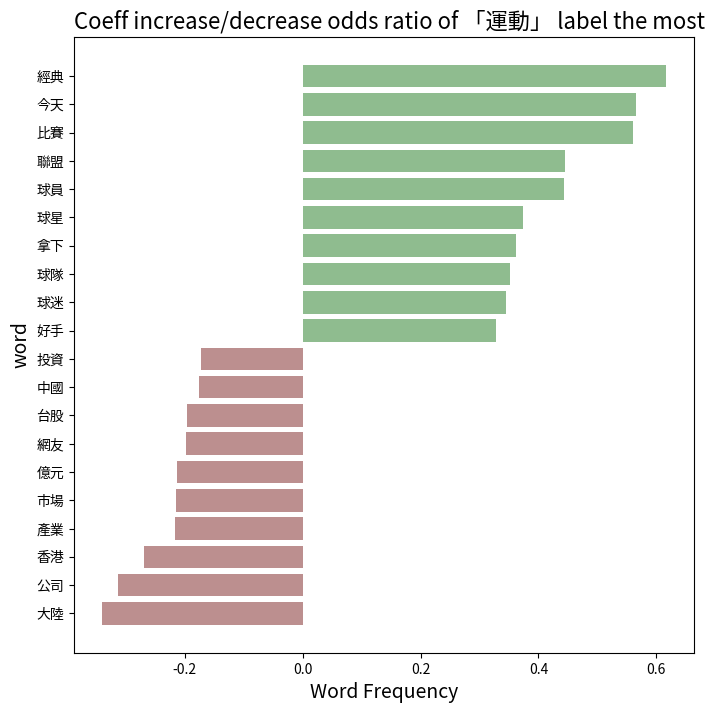

In [45]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names(), top_n=10)

「兩岸」中高係數的字多半與中國有關；「股市」則是投資、金融市場相關的字；而因為三月剛好是經典賽期間，「運動」中影響最大的字是經典。

## 6. 預測新聞類別

In [46]:
ct = pd.read_csv("./raw_data/ct_news_04.csv")
ct.dropna(inplace=True)
ct

,system_id,artUrl,artCatagory,artTitle,artDate,artContent,dataSource
0,1,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 蔡總統雷根圖書館演說恐生變,2023-04-01 04:10:00,蔡英文總統出訪中美洲友邦途中過境美國，美東時間3月30日晚間，在紐約受邀出席美國「哈德遜研究...,chinatimes
1,2,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯聯盟第1波 10藍委籲黨中央速徵召,2023-04-01 04:10:00,國民黨2024總統大選將以徵召方式決定人選，黨中央雖已積極展開徵詢，但目前黨內最強母雞就是新...,chinatimes
2,3,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥黨員投票水很深 宣布退選,2023-04-01 04:10:00,國民黨立委初選內鬥不斷，台北市第8選區（中正、文山）初選方式採37制，原本有意投入初選的北市...,chinatimes
3,4,https://www.chinatimes.com/newspapers/20230401...,政治,曾銘宗：侯目前民調是地板 表態後會上升,2023-04-01 04:10:00,曾多次準確預測台灣選舉結果的日本學者小笠原欣幸，日前評價國民黨潛在候選人、新北市長侯友宜民調...,chinatimes
4,5,https://www.chinatimes.com/newspapers/20230401...,政治,郝龍斌支持徵召 籲朱立倫公開說不選總統,2023-04-01 04:10:00,國民黨中央日前拍板以徵召方式提名2024總統參選人，但提名辦法、時程遲未公布，黨內憂心持續拖...,chinatimes
...,...,...,...,...,...,...,...
276,357,https://www.chinatimes.com/realtimenews/202304...,體育,T1聯盟》魔獸眼傷未癒 雲豹緊急宣告明天與英熊之戰不打,2023-04-01 20:10:00,為了避免出現去年12月18日「魔獸」霍華德說要打卻又突然不打的「鬧劇」，桃園永豐雲豹直到2日...,chinatimes
277,358,https://www.chinatimes.com/realtimenews/202304...,體育,中職》「覺得是個機會」 廖健富代打轟3分炮助桃猿逆轉兄弟,2023-04-01 21:05:00,中職34年新球季開打，樂天桃猿靠著代打的廖健富從中信兄弟王牌投手德保拉手中轟出逆轉3分炮，率...,chinatimes
278,359,https://www.chinatimes.com/realtimenews/202304...,體育,中職》十大好糗被笑翻 陳晨威漏踩壘包生涯頭一遭,2023-04-01 21:34:00,樂天桃猿快腿陳晨威在新球季開幕戰發生漏踩壘包，被促請裁決出局，回到休息室被隊友笑翻，還被郭永...,chinatimes
279,360,https://www.chinatimes.com/realtimenews/202304...,體育,中職》宋嘉翔開幕戰蹲捕獲好評 曾豪駒打100分,2023-04-01 21:52:00,樂天桃猿去年季中選秀首輪選進的捕手宋嘉翔擔綱開幕戰先發蹲捕任務，以18歲253天之齡打破開幕...,chinatimes


In [47]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,外媒爆 蔡總統雷根圖書館演說恐生變蔡英文總統出訪中美洲友邦途中過境美國，美東時間3月30日晚...,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...
1,挺侯聯盟第1波 10藍委籲黨中央速徵召國民黨2024總統大選將以徵召方式決定人選，黨中央雖已...,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯 聯盟 10 藍委籲 黨中央 徵召 國民黨 2024 總統大選 將以 徵召 方式 決定 ...
2,徐弘庭斥黨員投票水很深 宣布退選國民黨立委初選內鬥不斷，台北市第8選區（中正、文山）初選方式...,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 中正 文山 初選 ...
3,曾銘宗：侯目前民調是地板 表態後會上升曾多次準確預測台灣選舉結果的日本學者小笠原欣幸，日前評...,https://www.chinatimes.com/newspapers/20230401...,政治,曾銘宗 目前 民調 地板 表態 上升 曾多次 準確 預測 台灣 選舉 日本 學者 小笠 欣幸...
4,郝龍斌支持徵召 籲朱立倫公開說不選總統國民黨中央日前拍板以徵召方式提名2024總統參選人，但...,https://www.chinatimes.com/newspapers/20230401...,政治,郝龍斌 支持 徵召 籲朱 立倫公 開說 不選 總統 國民黨中央 日前 拍板 徵召 方式 提名...


In [48]:
ct['artCatagory'].value_counts()

財經    142
政治     71
兩岸     35
體育     32
Name: artCatagory, dtype: int64

In [49]:
mapper = {"財經":"股市", "政治":"兩岸", "體育":"運動", "兩岸": "兩岸"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']
y_pred = model_set[best_model_name].predict(vectorizer.transform(X))
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          兩岸       0.65      0.88      0.75       106
          股市       0.90      0.65      0.76       142
          運動       0.89      0.97      0.93        32

    accuracy                           0.78       280
   macro avg       0.81      0.83      0.81       280
weighted avg       0.81      0.78      0.77       280



In [50]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...,兩岸,兩岸
1,挺侯 聯盟 10 藍委籲 黨中央 徵召 國民黨 2024 總統大選 將以 徵召 方式 決定 ...,兩岸,兩岸
2,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 中正 文山 初選 ...,兩岸,股市
3,曾銘宗 目前 民調 地板 表態 上升 曾多次 準確 預測 台灣 選舉 日本 學者 小笠 欣幸...,兩岸,兩岸
4,郝龍斌 支持 徵召 籲朱 立倫公 開說 不選 總統 國民黨中央 日前 拍板 徵召 方式 提名...,兩岸,兩岸
...,...,...,...
276,T1 聯盟 魔獸 眼傷 雲豹 緊急 宣告 明天 英熊 之戰 避免出現 去年 12 18 魔獸...,運動,運動
277,中職 覺得 機會 廖健富 代打 分炮助 桃猿 逆轉 兄弟 中職 34 球季 開打 樂天 桃猿...,運動,運動
278,中職 十大 晨威漏 生涯 一遭 樂天 桃猿快 晨威 球季 開幕 發生 促請 裁決 出局 回到...,運動,運動
279,中職 宋嘉翔 開幕 捕獲 好評 曾豪駒 100 樂天 桃猿 去年 季中 選秀 首輪 選進 捕...,運動,運動


In [51]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
2,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 中正 文山 初選 ...,兩岸,股市
12,鳳馨 受害 王鴻薇 政府 台灣成 詐騙 之島 臉書 假冒 名人 詐騙 事件 相當 猖獗 作家...,兩岸,股市
26,立院 組挺侯 聯盟 侯友宜 齊心 齊力 國民黨 將以 徵召 方式 決定 2024 總統大選 ...,兩岸,股市
30,視察 清明 服務 總統 侯友宜 心連心 清明 連假 第一天 新北 各區 公墓 及納 骨塔 湧...,兩岸,運動
34,信回 台南 立委 成立 競辦 誓言 國民黨 搶下 一席 國民黨 分區 立委 信回 故鄉 台南...,兩岸,股市
...,...,...,...
210,反擊 拜登 第一槍 大陸 美光 美媒 晶片 大廠 危險 科技 戰愈 激烈 禁令 擴大 大陸 ...,股市,兩岸
211,全球 債務 狂飆 投資 大師 災難 降臨 遠超 2008 近期 銀行業 動盪 市場 惶恐不安...,股市,兩岸
212,蔚來 汽車 跨界 製造 手機 預計 今年 第三季 發布 香港 信報 報導 去年 李斌 透露 ...,股市,兩岸
213,人民幣 影響力 巴西 第二 外匯存底 貨幣 中國 央視 報導 巴西 央行 最新 報告 指出 ...,股市,兩岸


In [52]:
false_pred.loc[false_pred['artCatagory']=='股市', :]

,words,artCatagory,pred
73,跟隨 美國 腳步 中國 日本 限制 23 半導體 設備 出口 日本 經濟 產業 大臣 西村 ...,股市,兩岸
74,反制 第一槍 陸對 美光 產品 啟動 網路 安全 審查 中國 網信 31 晚間 公告 保障 ...,股市,兩岸
78,製造業 PMI 預期 大陸 防疫 鬆綁 經濟 持續 回升 大陸 國家統計局 31 公布 製造...,股市,兩岸
80,加速 復甦 世銀上 東亞 今年 經濟 成長 世銀 預測 EAP 包括 大陸 在內 23 經濟...,股市,兩岸
84,晶片 法案 委屈 台廠 經部 協助 溝通 美國 晶片 法案 鉅額 補貼 廣邀 世界 各國 半...,股市,兩岸
87,電信業 五變 旭東 嫌多 國內 兩大 電信 合併案 NCC 已有 條件 核准 公平 核准 國...,股市,兩岸
89,發現 提早 入帳 數位 發展部 晚間 對此 表示 原則上 連假 第一個 營業日 日起 000...,股市,兩岸
91,立委 力倡 主權 基金 央行 不宜 挪用 外匯存底 行政院長 陳建仁 立法院 備詢 民眾 黨...,股市,兩岸
94,脫歐 最大 進展 加入 CPTPP 英國 31 宣布 敲定 加入 太平洋 夥伴 全面進步 協...,股市,兩岸
95,鄧振中 積極爭取 台灣 入會 鄧振中 專心 處理 英國 關係 過去 會員國 尚未 台灣 大陸...,股市,兩岸


In [53]:
pprint(false_pred['words'][74])

('反制 第一槍 陸對 美光 產品 啟動 網路 安全 審查 中國 網信 31 晚間 公告 保障 關鍵 資訊 基礎設施 供應鏈 安全 防範 產品 問題 隱患 '
 '造成 網路 安全 風險 維護 國家 安全 網路 安全 審查 辦公室 將依 國家 安全法 網絡安全 網路 安全 審查 辦法 美光 公司 銷售 產品 實施 '
 '網路 安全 審查 此前 中國 網路 安全 審查 先後 2021 針對 滴滴 出行 滿滿 貨車 BOSS 直聘 大陸 互聯網 平台 實施 成為 中企 境外 '
 '上市 監管 措施 一環 本次 網信 美光 啟動 網路 安全 審查 應是 外企 實施 首例 中國 晶片 近期 遭美 荷等國 加強 圍堵 值得注意 中國 '
 '記憶體 晶片 大廠 長江 存儲 列入 美國 貿易 黑名單 陸媒集 微網 披露 美光 背後 始作俑者 一直 政治 投機者 角色 美國 遊說 數據 顯示 '
 '2018 以來 美國政府 遊說 次數 最多 美國 半導體 企業 年來 斥資 954 萬美元 用於 遊說 唯一 提出 中國 競爭 相關 問題 公司')


模型對另一個新聞網的預測結果比較普通。不過，其中很大一部分預測錯的類別，是把「股市」預測成「兩岸」。當我們把這個類別的錯誤挑出來看，可以發現這些預測錯的股市新聞，多半也算與國際地緣政治相關的財經新聞。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。
* 在這裡可以看到個不同模型的 F1-score 都不會差到太多，代表就算只用 1000 維的 DTM 來代表一篇文章，其實也是有一定程度地的預測能力。

## 6. 教學目標
1. 能夠利用 DTM 將文章表示成一串數字，以利後續的分析或預測任務使用
2. 能夠使用機器學習流程，訓練一個文集分類模型
    * 額外提問：只要能夠把文字資料轉換成 `input` 與 `label` 的形式，就能夠來訓練預測模型。例如本週就是將新聞轉成數字 input，label 為新聞類別。文字分析中有哪些可能的應用場景？
        * 用企業的財報預測企業股價/ROA?
        * 用總統候選人的選前演講稿預測得票率？
3. 能夠解釋在可解釋模型中，詞頻/tfidf 作為 input feature 的意義

## 附錄

In [54]:
# 定義模型訓練組合
## 不做 cross validation, 用 test data 來評估模型的版本
## pipeline: 資料處理 vectorizer + 分類器
def train(vectorizer, clf, X_train, y_train, X_test, y_test):

    ## train classifier
    vec_train = vectorizer.fit_transform(X_train).toarray()
    vec_test = vectorizer.transform(X_test).toarray()
    clf.fit(vec_train, y_train)
    

    ## test classifier
    y_pred = clf.predict(vec_test)
    y_pred_proba = clf.predict_proba(vec_test)

    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    ## Accuracy, Precision, Recall, F1-score
    print(classification_report(y_test, y_pred))

    classes = clf.classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0].plot(
            fpr,
            tpr,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr)),
        )
    ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
    ax[0].set(
        xlim=[-0.05, 1.0],
        ylim=[0.0, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate (Recall)",
        title="Receiver operating characteristic",
    )
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1].plot(
            recall,
            precision,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
        )
    ax[1].set(
        xlim=[0.0, 1.05],
        ylim=[0.0, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title="Precision-Recall curve",
    )
    ax[1].legend(loc="best")
    ax[1].grid(True)

    plt.show()

    # return the model object
    return classification_report(y_test, y_pred, output_dict=True)


              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



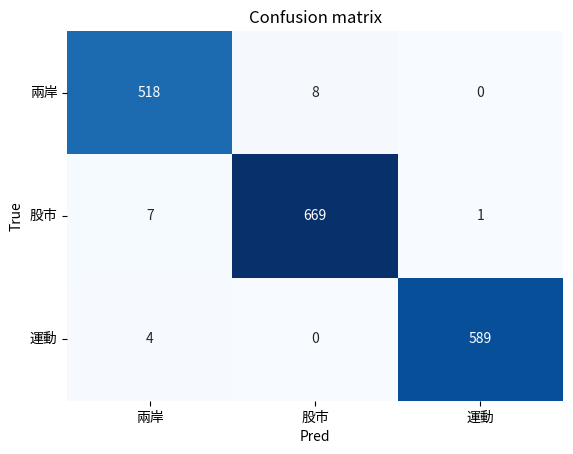

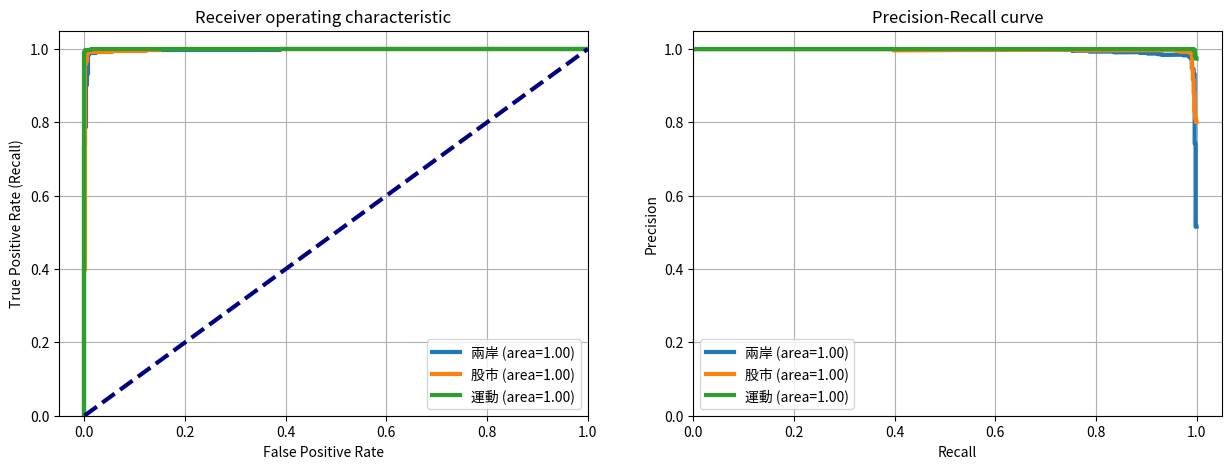

{'兩岸': {'precision': 0.9792060491493384,
  'recall': 0.9847908745247148,
  'f1-score': 0.9819905213270143,
  'support': 526},
 '股市': {'precision': 0.9881831610044313,
  'recall': 0.9881831610044313,
  'f1-score': 0.9881831610044313,
  'support': 677},
 '運動': {'precision': 0.9983050847457627,
  'recall': 0.9932546374367622,
  'f1-score': 0.9957734573119189,
  'support': 593},
 'accuracy': 0.9888641425389755,
 'macro avg': {'precision': 0.9885647649665108,
  'recall': 0.9887428909886361,
  'f1-score': 0.9886490465477881,
  'support': 1796},
 'weighted avg': {'precision': 0.9888960451596821,
  'recall': 0.9888641425389755,
  'f1-score': 0.9888756538997647,
  'support': 1796}}

In [55]:
data = udn
X = data["words"]
y = data["artCatagory"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
train(vectorizer, clf, X_train, y_train, X_test, y_test)

    畫出決策樹的 code

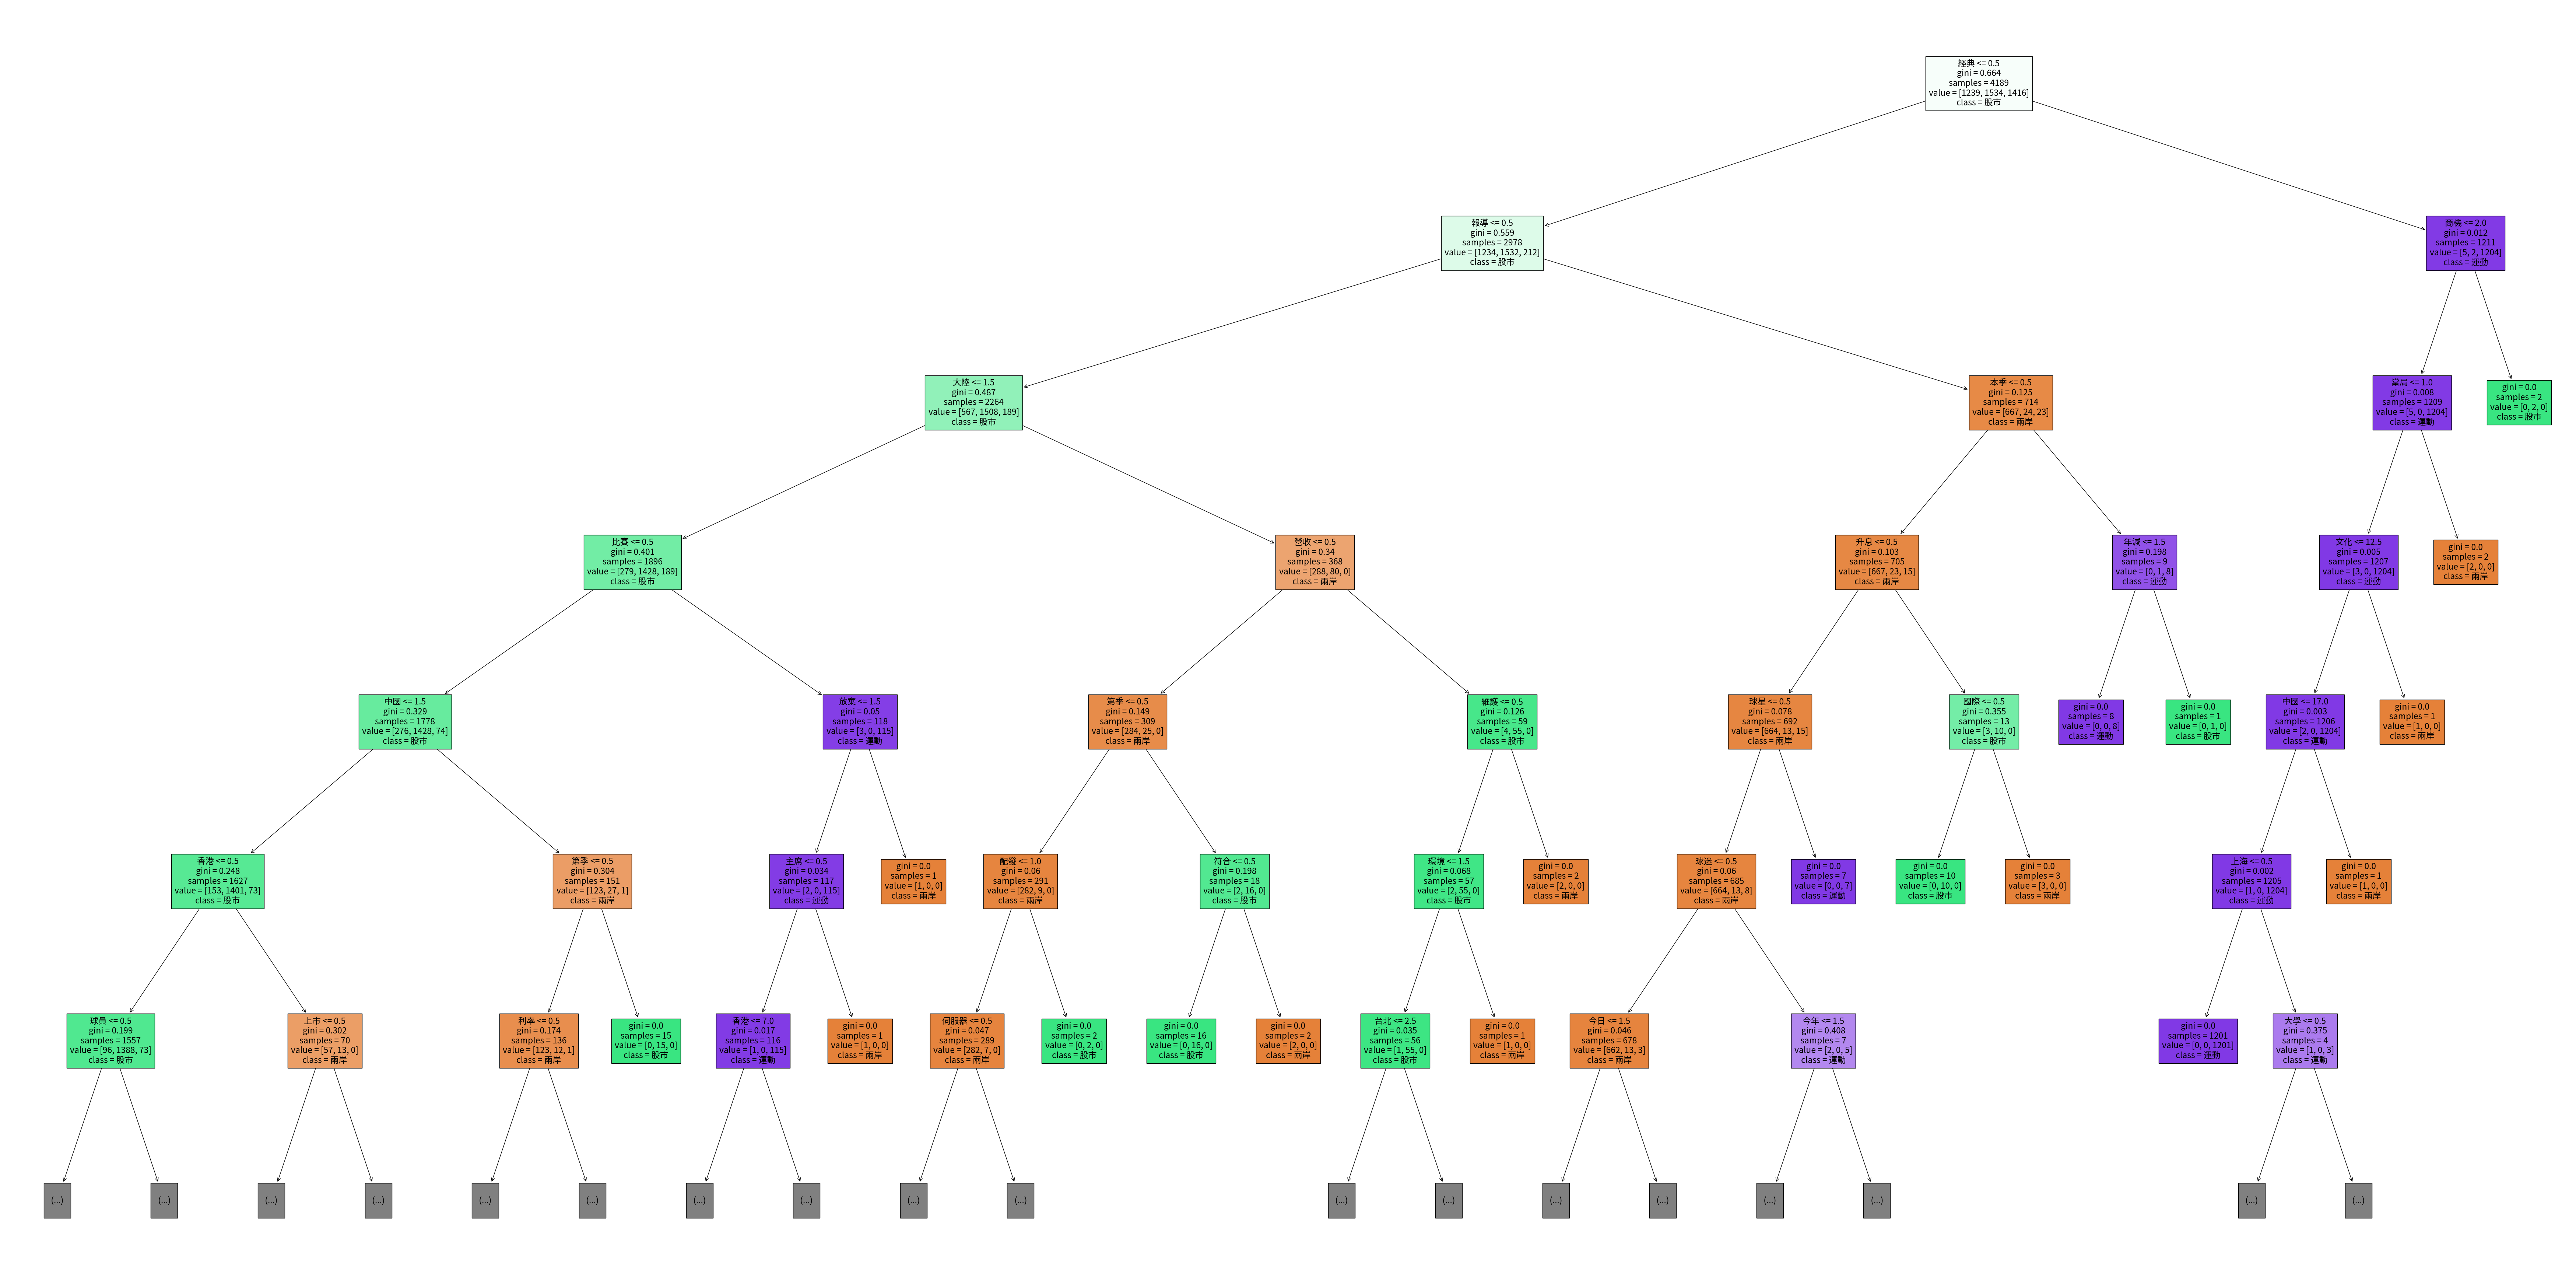

In [56]:
fig = plt.figure()
fig.set_size_inches(90, 45)
plot_tree(
    model_set["clf_dtree"], 
    max_depth=6, # 最大深度
    feature_names=vectorizer.get_feature_names(), 
    class_names=model_set["clf_dtree"].classes_,
    filled=True
)
fig.savefig("decistion_tree.png")